# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [3]:
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV

In [4]:
import logging
logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)

## Part 1: Titanic survival prediction

### Dataset

Read the description here: https://www.kaggle.com/c/titanic/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/titanic/overview/evaluation.  


In [5]:
PATH = "./data/"

In [6]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [7]:
data.head(25)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [8]:
## your code

females = data[data.Sex == 'female']
males = data[data.Sex == 'male']
survived_passengers = data[data.Survived == 1]

print('Females count: ' + str(females.shape[0]))
print('Males count: ' + str(males.shape[0]))
print('Survived passengers count: ' + str(survived_passengers.shape[0]))

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Females count: 314
Males count: 577
Survived passengers count: 342


In [9]:
def get_sorted_correlations(data):
    #correlation matrix
    data_correlation = data.corr(method='pearson')

    # reshaped matrix
    result = []
    for row in data_correlation.index: 
        for col in data_correlation.columns:
            labels = [row, col]
            labels.sort()
            if row != col:
                result.append([abs(data_correlation.at[row,col]), labels[0] + ' ' + labels[1]])

    numpy_data = np.array(result, dtype=object)
    reshaped_correlation = pd.DataFrame(data=numpy_data, columns=["corr", "labels"])

    # drop duplicates and sort
    reshaped_correlation = reshaped_correlation.drop_duplicates(subset=['labels'])
    sorted_reshaped_correlation = reshaped_correlation.sort_values(inplace=False, ascending=False, by='corr')
    
    return sorted_reshaped_correlation   

Correlation between the gender and the survival
            Gender  Survived
Gender    1.000000  0.543351
Survived  0.543351  1.000000
Sorted correlations
         corr           labels
10     0.5495      Fare Pclass
5    0.543351  Gender Survived
21   0.414838      Parch SibSp
7    0.369226       Age Pclass
0    0.338481  Pclass Survived
14   0.308247        Age SibSp
4    0.257307    Fare Survived
29   0.245489     Gender Parch
28   0.216225       Fare Parch
15   0.189119        Age Parch
35   0.182333      Fare Gender
22   0.159651       Fare SibSp
11     0.1319    Gender Pclass
23   0.114631     Gender SibSp
16  0.0960667         Age Fare


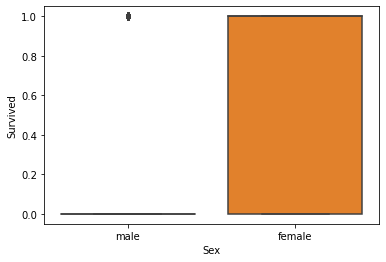

In [10]:
# Correlation between the gender and the survival

# Introduce synthetic binary feature 'Gender': 1 - female, 0 - male
data['Gender'] = np.where(data['Sex'] == 'female', 1 , 0)
data.head()

# Correlation matrix
print('Correlation between the gender and the survival')
features = ['Gender', 'Survived']
data_correlation = data[features].corr(method='pearson')
print(data_correlation)

print('Sorted correlations')
sorted_correlation = get_sorted_correlations(data)
print(sorted_correlation.head(15))

# Plot
sns.boxplot(x='Sex', y='Survived', data=data);

< your thoughts >

Result:
Looks like there is a strong correlation between survived and gender as correlation index between them is 0.543351.

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

array([[<AxesSubplot:title={'center':'Age'}>]], dtype=object)

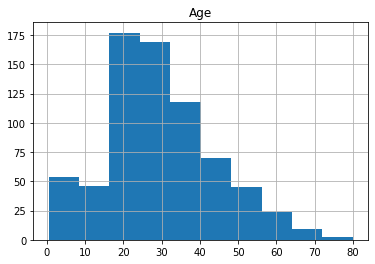

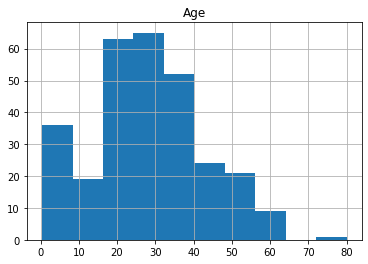

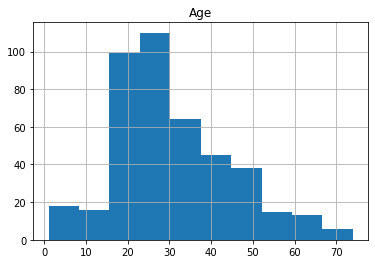

In [11]:
## your code

# age distribution for all passengers
data.hist(column='Age', bins=10)

# age distribution for survived passengers
survived_passengers = data[data.Survived == 1]
survived_passengers.hist(column='Age', bins=10)

# age distribution for deceased passengers
deceased_passengers = data[data.Survived == 0]
deceased_passengers.hist(column='Age', bins=10)

In [12]:
#average and the median age of survived and deceased passengers

print('Average and median age of survived: ' + str(survived_passengers['Age'].mean()) + ', ' + str(survived_passengers['Age'].median()))

print('Average and median age of deceased: ' + str(deceased_passengers['Age'].mean()) + ', ' + str(deceased_passengers['Age'].median()))


Average and median age of survived: 28.343689655172415, 28.0
Average and median age of deceased: 30.62617924528302, 28.0


< your thoughts >

Do age distributions differ for survived and deceased passengers? Why?

Seems like there are much more persons under 10 among survived because it was agreed to help them first.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

Average and median survival for class 1: 0.6296296296296297, 1.0
Average and median survival for class 2: 0.47282608695652173, 0.0
Average and median survival for class 3: 0.24236252545824846, 0.0


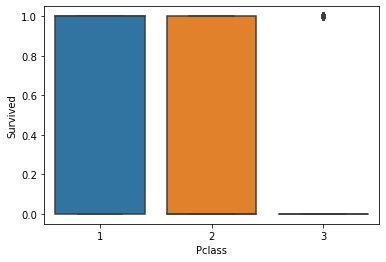

In [13]:
## your code

# What class was "the safest"?


class_1 = data[data.Pclass == 1]
class_2 = data[data.Pclass == 2]
class_3 = data[data.Pclass == 3]

print('Average and median survival for class 1: ' + str(class_1['Survived'].mean()) + ', ' + str(class_1['Survived'].median()))
print('Average and median survival for class 2: ' + str(class_2['Survived'].mean()) + ', ' + str(class_2['Survived'].median()))
print('Average and median survival for class 3: ' + str(class_3['Survived'].mean()) + ', ' + str(class_3['Survived'].median()))


sns.boxplot(x='Pclass', y='Survived', data=data);

Average and median survival for Embarked C: 0.5535714285714286, 1.0
Average and median survival for Embarked Q: 0.38961038961038963, 0.0
Average and median survival for Embarked S: 0.33695652173913043, 0.0


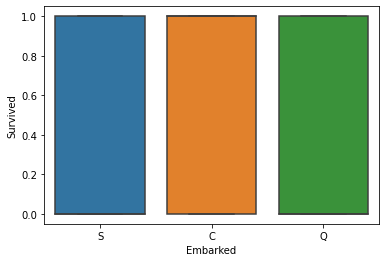

In [14]:
# Is there any relationship between the embarkation port and the survival?

embarked_C = data[data.Embarked == 'C']
embarked_Q = data[data.Embarked == 'Q']
embarked_S = data[data.Embarked == 'S']

print('Average and median survival for Embarked C: ' + str(embarked_C['Survived'].mean()) + ', ' + str(embarked_C['Survived'].median()))
print('Average and median survival for Embarked Q: ' + str(embarked_Q['Survived'].mean()) + ', ' + str(embarked_Q['Survived'].median()))
print('Average and median survival for Embarked S: ' + str(embarked_S['Survived'].mean()) + ', ' + str(embarked_S['Survived'].median()))


sns.boxplot(x='Embarked', y='Survived', data=data);

< your thoughts >

Seems like the first class is the safest because median survival is 1 for them.
The same for Embarked = C.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [15]:
## your code

data.isna().mean().round(4) * 100

Survived     0.00
Pclass       0.00
Name         0.00
Sex          0.00
Age         19.87
SibSp        0.00
Parch        0.00
Ticket       0.00
Fare         0.00
Cabin       77.10
Embarked     0.22
Gender       0.00
dtype: float64

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

< your thoughts >

Age column has about 20% of missed values. There are several ways to cope with them:
1) fill missed values with average column value;
2) remove rows with empty age.
The second option looks better because it doesn't create artifactory data.

Cabin column has about 77% of missed values. Sesms like the good option is just to remove that column
because it is hard to guess reasonable data to fill it.

Embarked column has very few empty values, the rows could be removed.

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [16]:
y = data['Survived']

In [17]:
## your code

# prepare the data

def prepare_data(X):
    
    # Introduce synthetic binary feature 'Gender': 1 - female, 0 - male
    X['Gender'] = np.where(X['Sex'] == 'female', 1 , 0)

    # Remove rows with empty 'Embarked' column
    filter = ~X['Embarked'].isnull()
    X = X[filter]

    # Fill absent 'Age' with mean column value
    X['Age'] = X['Age'].fillna(X['Age'].median())

    # Introduce synthetic binary feature 'Embarked_synthetic': 1 - C, 0 - S, Q
    X['Embarked_synthetic'] = np.where(X['Embarked'] == 'C', 1 , 0)
    
    return X

In [18]:
feature_cols = ['Pclass', 'Age', 'Embarked_synthetic', 'Gender']
prepared_titanic_data = prepare_data(data)
prepared_titanic_data[feature_cols].isna().sum()

<ipython-input-17-68901313da06>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Age'] = X['Age'].fillna(X['Age'].median())
<ipython-input-17-68901313da06>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Embarked_synthetic'] = np.where(X['Embarked'] == 'C', 1 , 0)


Pclass                0
Age                   0
Embarked_synthetic    0
Gender                0
dtype: int64

In [19]:
X = prepared_titanic_data[feature_cols]
y = prepared_titanic_data['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [20]:
def fit_plot_confusion(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)

    logging.info(clf.best_params_)

    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return clf.best_estimator_

INFO:root:{'C': 0.1, 'penalty': 'l1'}


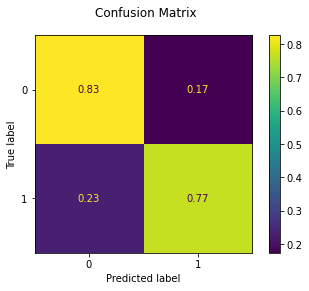

0.8033707865168539

In [21]:
# fit a linear regression model

lr_param_grid = {'C': [0.01, 0.1, 1.0, 10.0],
                 'penalty': ['l1', 'l2']}
lr_clf = GridSearchCV(LogisticRegression(random_state=42, max_iter=1000, solver='saga', n_jobs=-1), lr_param_grid)

best_estimator_regr = fit_plot_confusion(lr_clf, X_train, y_train, X_test, y_test)

y_pred_regr = best_estimator_regr.predict(X_test)
metrics.accuracy_score(y_pred=y_pred_regr, y_true=y_test)

INFO:root:{'n_neighbors': 30, 'weights': 'distance'}


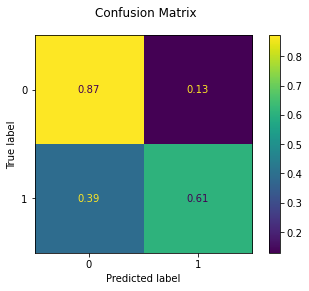

0.7696629213483146

In [22]:
# fit a KNN model

knn_param_grid = {'n_neighbors': [1, 2, 3, 5, 30, 100], 'weights': ['uniform', 'distance']}
knn_clf = GridSearchCV(KNeighborsClassifier(n_jobs=-1), knn_param_grid)

best_estimator_knn = fit_plot_confusion(knn_clf, X_train, y_train, X_test, y_test)

y_pred_knn = best_estimator_knn.predict(X_test)
metrics.accuracy_score(y_pred=y_pred_knn, y_true=y_test)

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [23]:
## your code


test_data = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv')).set_index('PassengerId')

test_data.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [24]:
# prepare data

titanic_test_data = prepare_data(test_data)
titanic_test_data = titanic_test_data[feature_cols]
titanic_test_data.isna().sum()

Pclass                0
Age                   0
Embarked_synthetic    0
Gender                0
dtype: int64

In [25]:
# make the predictions with linear regression model

y_pred_regr_2 = best_estimator_regr.predict(titanic_test_data)

In [26]:
# make the predictions with KNN model

y_pred_knn_2 = best_estimator_knn.predict(titanic_test_data)

Load the test set and make the predictions. Submit them to kaggle and see the results :)
Select the best model, load the test set and make the predictions. Submit them to kaggle.

**Note**. X points will depend on your kaggle leaderboard score.
$$ f(score) = 0.5, \ \ 0.76 \leq score < 0.78,$$
$$ f(score) = 1.0, \ \ 0.78 \leq score < 0.81,$$ 
$$ f(score) = 2.5, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

In [27]:
## your code

"""
You should submit a csv file with exactly 418 entries plus a header row.

The file should have exactly 2 columns:

PassengerId (sorted in any order)
Survived (contains your binary predictions: 1 for survived, 0 for deceased)
"""

def prepare_result_for_kaggle(X, predictions):
    X['Predicted'] = predictions
    X['Survived'] = np.where(X['Predicted'] >= 0.5, 1 , 0)
    return X[['Survived']]

processed_predictions = prepare_result_for_kaggle(test_data, y_pred_regr_2)
print(processed_predictions.shape)


processed_predictions.to_csv('submission.csv')

read_processed_predictions = pd.read_csv('submission.csv')
print(read_processed_predictions.columns)
read_processed_predictions.head()

(418, 1)
Index(['PassengerId', 'Survived'], dtype='object')


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


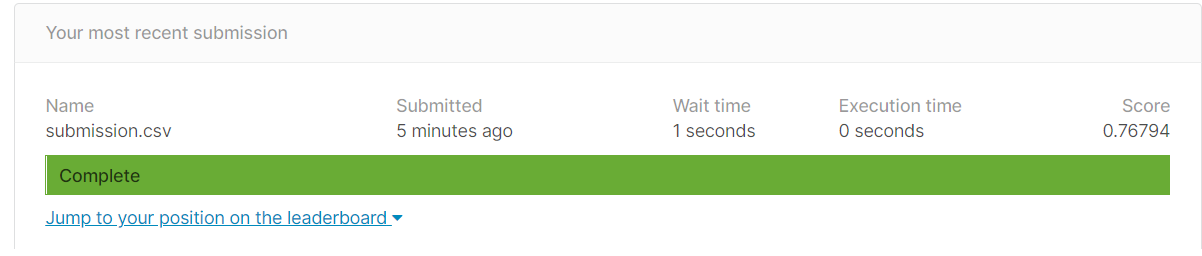

In [28]:
from IPython.display import Image
Image(filename='submission.png')

## Part 2: Porto Seguro’s Safe Driver Prediction

Let's build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year.
Read the detailed description and download the dataset https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data. Put the data into *./data/porto/*.

In [ ]:
insurance_data = pd.read_csv(os.path.join(PATH, 'porto', 'train.csv')).set_index('id')

In [ ]:
insurance_data.head()

Let's skip EDA for now. We'll use SGDClassifier and build a simple baseline: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html.
Note that loss='log' gives logistic regression.

In [ ]:
y = insurance_data['target']
X = insurance_data.drop(columns=['target'])

In [ ]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SGDClassifier(loss='log', alpha=0.001, n_jobs=-1, random_state=14))])

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
clf = pipeline.fit(X_train, y_train)

We'll calculate the model accuracy:

In [ ]:
accuracy_score(y_true=y_valid, y_pred=clf.predict(X_valid))

Wow! Our model gets ~0.963 accuracy! But is it really good?...

Let's plot the confusion matrix and analyze the errors.

In [ ]:
disp = plot_confusion_matrix(clf, X_valid, y_valid,
                             cmap=plt.cm.Blues,
                             normalize=None)

Well, it turns out that our model is completely useless. Let's calculate some basic statistics:

In [ ]:
insurance_data.describe()

As you see, there are less than 4% of positive examples, so we have to deal with a highly imbalanced dataset.

In [ ]:
sns.countplot(x='target', data=insurance_data)
plt.show()

Accuracy is not informative here and the Normalized Gini Coefficient will be used instead: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/overview/evaluation.

In [ ]:
# Code for calculating Normalized gini coefficient
# https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703
def gini(actual, pred, cmpcol = 0, sortcol = 1):  
    assert(len(actual) == len(pred))  
    epsilon = 1e-7
    values = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)  
    values = values[np.lexsort((values[:, 2], -1 * values[:, 1]))]  
    total = values[:, 0].sum() 
    gini_sum = (values[:, 0].cumsum().sum() + epsilon) / (total + epsilon)  
  
    gini_sum -= (len(actual) + 1) / 2  
    return gini_sum / len(actual)  
  
def gini_normalized(a, p):  
    '''Function to calculate the normalized gini coefficient'''
    return gini(a, p) / gini(a, a)

**(1.5 points)** Prove that the **Normalized Gini Coefficient** is equivalent to **2 x AUC - 1** :

< your proof >

**(0.5 points)** By the way, what other metrics could you suggest for this problem?

< your thoughts >

Let's calculate the Normalized Gini Coefficient:

In [ ]:
y_pred = clf.predict_proba(X_valid)[:, 1]

In [ ]:
gini_normalized(y_valid, y_pred)

**(0.5 points + Y bonus points)** Try different approaches: oversampling / undersampling, careful feature analysis and feature engineering, etc., to get a reasonable pipeline and improve the model quality. Use cross-validation for model evaluation.

Select the best model, load the test set and make the predictions. Submit them to kaggle.
Y bonus points will be calculated as $\frac{round(200 * \max(score - 0.253, 0))}{2}$, where *score* is your kaggle leaderboard score.

Note: do not use any classification models which have not been covered in the lessons yet.

In [ ]:
## your code